### Updated APC DNA Surveillance

#### Scope:
- To re-run DNA Surveillance for APC wells using our updated protocols e.g. QC
- To eventually integrate DNA Surveillance results with a multi-regression reservoir model
- In this notebook we'll focus on the wells for which we have geology, completions and production data (~120 wells)

#### General Tools:

In [1]:
# General Tool Imports

import os
os.environ['PATH'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/bin:' + os.environ['PATH']
os.environ['PROJ_LIB'] = '/home/jovyan/my-conda-envs/qiime2-2018.8/share/proj'

import numpy as np
import pandas as pd
import collections
from pickle import load, dump
import lasio

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from mpl_toolkits.basemap import Basemap
from matplotlib.lines import Line2D

# Biota Imports
import biota
from biota.database import (get_samples,
                            get_sample_data)
from biota.util import (rarefy,
                        make_tree,
                        get_dms,
                        filter_dm_and_map,
                        get_tax_table)
import biota.plot as bpl # used for internal plotting code

# SourceTracker Imports
from ipyparallel import Client
from sourcetracker._sourcetracker import gibbs

# Clustering imports
from scipy.spatial.distance import pdist
from scipy.cluster import hierarchy

from scipy.stats import ttest_ind

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Plot images in the notebook
%matplotlib inline

#### Data Query:

In [2]:
# First query to get samples
query = {'Company': 'anadarko.petroleum.corporation',
         'Basin':'permian.basin',
         'FieldSampleType':'produced.fluid'}

samples_, data, features = get_sample_data(query)

The filtering function dropped 0 samples and 25000 features
The sample method dropped 5 samples with no sequence data.


In [3]:
# Read geology, completions and production data for ~120 wells
WellData = pd.read_csv("WellData.csv", index_col=0)

In [4]:
# Only take samples from wells for which we have geology, completions and production data (~120 wells)
samples = samples_.loc[samples_.Well.isin(WellData.index)].copy()

In [5]:
# Quickly look at the sample types we've pulled down
samples.SequenceSampleType.value_counts()

oil.water    1017
water          38
oil            35
Name: SequenceSampleType, dtype: int64

#### Assigning Formation Color and Marker for Plotting:

In [6]:
WellData['FormationColor'] = WellData.Formation

In [7]:
WellData.FormationColor.replace({'w1.alpha': 'red',
                                'w2.alpha': 'pink',
                                'shale.alpha':'orange',
                                'upper.beta': 'blue',
                                'middle.beta': 'green',
                                'lower.beta': 'purple',
                                'upper.delta':'black'}, inplace=True)

In [8]:
WellData['Marker'] = WellData.Formation

In [9]:
WellData.Marker.replace({'w1.alpha': 'o',
                        'w2.alpha': 'o',
                        'shale.alpha':'o',
                        'upper.beta': 'd',
                        'middle.beta': 'd',
                        'lower.beta': 'd',
                        'upper.delta':'s'}, inplace=True)

#### Data QC:

In [10]:
# Adding sequences per sample to the Samples dataframe
samples['SequencesPerSample'] = data.sum(axis=1) # sum the counts on a per row (per sample) basis

In [11]:
nec_plate_name = samples.NECPlate.dropna().unique().tolist()
print(nec_plate_name)

['NECs.plate.166.20180212', 'NECs.plate.175.20180301']


In [12]:
query = {'$or':[{'_id': {'$in': samples.index.tolist()}},
                {'ExtractionPlate': {'$in': nec_plate_name}}]}

In [13]:
# use non-default params for querying SequenceData
params = {'coll_1': 'SequenceSampleData',
         'coll_2': 'FieldData',
         'id_1': 'SequenceSampleUUID',
         'id_2': 'FieldSampleUUID'}

In [14]:
samples, data, features = get_sample_data(query, **params)

The filtering function dropped 0 samples and 16644 features


In [15]:
# create a dataframe for the fluid samples only
# only the subset of fluid samples for which we have geology, completions and production data (~120 wells) 
fluids = samples.loc[(samples.SequenceSampleType.isin(['oil','water','oil.water']) & 
                      samples.Well.isin(WellData.index))].copy()
# create a dataframe for the NECs only
necs = samples.loc[samples.SequenceSampleType.isin(['negative.control','negative.extraction.control'])].copy()

In [16]:
# get the list of wells for which Formation is not specified in our database
unspecified = fluids.loc[fluids.Formation.isnull()].Well.unique().tolist().copy()

In [17]:
# Assign date online
# Assign target formation to wells with unspecified target formation
for well, g in WellData.iterrows():
    fluids.loc[fluids.Well == well, 'FirstProductionDate'] = g.FirstProdDate
    fluids.loc[fluids.Well == well, 'FormationColor'] = g.FormationColor
    fluids.loc[fluids.Well == well, 'Marker'] = g.Marker
    if well in unspecified:
        fluids.loc[fluids.Well == well, 'Formation'] = g.Formation

In [18]:
# Calculate how long into the lives of the wells the samples have been collected
fluids['DaysOnline'] = pd.to_datetime(fluids['CollectionDate']) - pd.to_datetime(fluids['FirstProductionDate'])
fluids.DaysOnline = fluids.DaysOnline.astype(int) /(24*3600*1e9)

In [19]:
# Create composite nec source sample
# Get only nec samples from data
data_sources = data.reindex(index=necs.index).copy()

# Rarefy each nec sample (row) in data_sources
data_sources = rarefy(data_sources, 5000)

# Group together by summing to form a single nec sample
data_sources = data_sources.groupby(necs.SequenceSampleType).sum()

# Create the sinks
data_sinks = data.reindex(index=fluids.index).copy()

# rarefy each fluid sample individually
data_sinks = rarefy(data_sinks, 5000)

In [22]:
# set source tracker parameters
st_params = {'alpha1' : 0.01,
             'alpha2' : 0.01, 
             'beta' : 10, 
             'burnin' : 50,
             'delay' : 10, 
             'restarts' : 2, 
             'draws_per_restart' : 5,
             'cluster': Client()}

In [20]:
# Run SourceTracker or just load saved results
try:
    mp = load(open('./pickles/fluids_vs_nec.pickle', 'rb'))

# If the above pickle file is not found, we'll run SourceTracker    
except:
    mp, std, tables = gibbs(data_sources, data_sinks, **st_params)
    dump(mp, open('./pickles/fluids_vs_nec.pickle', 'wb'))

In [21]:
# Add each samples PCR Yield to the mp table
mp['PCRYield'] = fluids.PCRYield

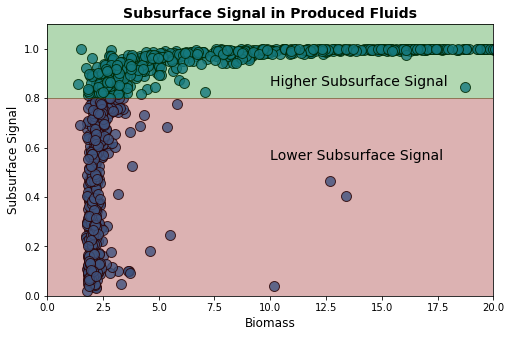

In [23]:
# Create a single plot
fig, ax = plt.subplots(1, figsize=(8, 5))

# Plot a scatter with x=PCRYield, and y=Unknown using the mp dataframe
ax.scatter(mp.PCRYield, mp.Unknown, s=100, edgecolor='k', alpha=0.8)

# Relabel x,y axis and set pretty limits
ax.set_ylabel('Subsurface Signal', size=12)
ax.set_xlabel('Biomass', size=12)
ax.set_title('Subsurface Signal in Produced Fluids', size=14, weight='bold')
ax.set_xlim(0, 20)
ax.set_ylim(0, 1.1)

# Create patches that capture the 0-80% y-axis, and 80-100% y-axis
# to denote higher and lower subsurface signal sections
highsignal = Rectangle((0, 0.8), 25, 0.3, alpha=0.3, color='green')
lowsignal = Rectangle((0, 0.0), 25, 0.8, alpha=0.3, color='darkred')

# Add patches and annotate
ax.add_patch(highsignal)
ax.annotate('Higher Subsurface Signal', (10, 0.85), color='black', size=14)
ax.add_patch(lowsignal)
ax.annotate('Lower Subsurface Signal', (10, 0.55), color='black', size=14)
,

fig.savefig('./images/fluids_qc.png', dpi=300, bbox_inches='tight')

In [22]:
fluids['SequencesPerSample'] = data.sum(axis=1) # sum the counts on a per row (per sample) basis

In [23]:
fluids['Unknown'] = mp.Unknown

In [24]:
# samples having at least 5000 sequences
fluids[fluids.SequencesPerSample >= 5000].shape[0]

1085

In [28]:
# total number of fluid samples
fluids.shape[0]

1090

In [29]:
# percentage of total fluid samples passing QC
round(100*mp[mp.Unknown > 0.8].shape[0] / fluids.shape[0], 2)

56.61

In [25]:
fluids['PassQC'] = 0
fluids.loc[(fluids.Unknown > 0.8)&(fluids.SequencesPerSample > 5000), 'PassQC'] = 1

In [26]:
fluids.PassQC.sum()

617

In [27]:
fluids_qc = fluids.groupby('Formation').count()[['BarcodeSequence']]
fluids_qc['PassQC'] = fluids.groupby('Formation').sum()[['PassQC']]
fluids_qc['PercentPassed'] = round((fluids_qc.PassQC / fluids_qc.BarcodeSequence)*100, 1)

In [33]:
formation_order = ['w1.alpha', 'w2.alpha', 'shale.alpha', 'upper.beta', 
                   'middle.beta', 'lower.beta', 'upper.delta']

In [34]:
fluids_qc.reindex(index=formation_order)

,BarcodeSequence,PassQC,PercentPassed
Formation,,,
w1.alpha,202.0,155.0,76.7
w2.alpha,NaN,NaN,NaN
shale.alpha,10.0,0.0,0.0
upper.beta,161.0,41.0,25.5
middle.beta,602.0,347.0,57.6
lower.beta,72.0,36.0,50.0
upper.delta,43.0,38.0,88.4


##### Thoughts:
- The usual shape of the curve for Subsurface Signal vs. PCR Yield is observed
- None of the shale.alpha fluids pass QC
- Less than half of upper.beta and lower.beta fluids pass QC

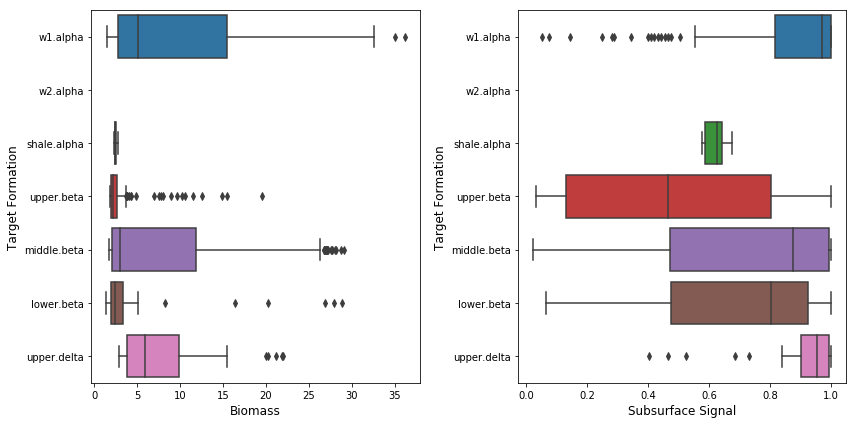

In [59]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
axes = axes.ravel()

sns.boxplot(y="Formation", x="PCRYield", 
            data=fluids, order=formation_order, ax=axes[0])
axes[0].set_ylabel('Target Formation', size=12)
axes[0].set_xlabel('Biomass', size=12)

sns.boxplot(y="Formation", x="Unknown", 
            data=fluids, order=formation_order, ax=axes[1])
axes[1].set_ylabel('Target Formation', size=12)
axes[1].set_xlabel('Subsurface Signal', size=12)

fig.tight_layout()

In [35]:
# average PCRYield and Subsurface Signal for each well
fluids_wells0 = fluids.groupby('Well').mean()[['PCRYield','Unknown']]

In [36]:
WellData2 = pd.concat([WellData, fluids_wells0], axis=1)

In [37]:
# list of properties we want to plot against PCR Yield and Subsurface Signal
plotcolumns = ['PHIT','SWT','VCL','BVW','ISOCHORE','P_Res','CumOil_24Months_F','WOR24m','GOR24m','PPG','Rate_per_cluster','PRIMARY_FLUID']

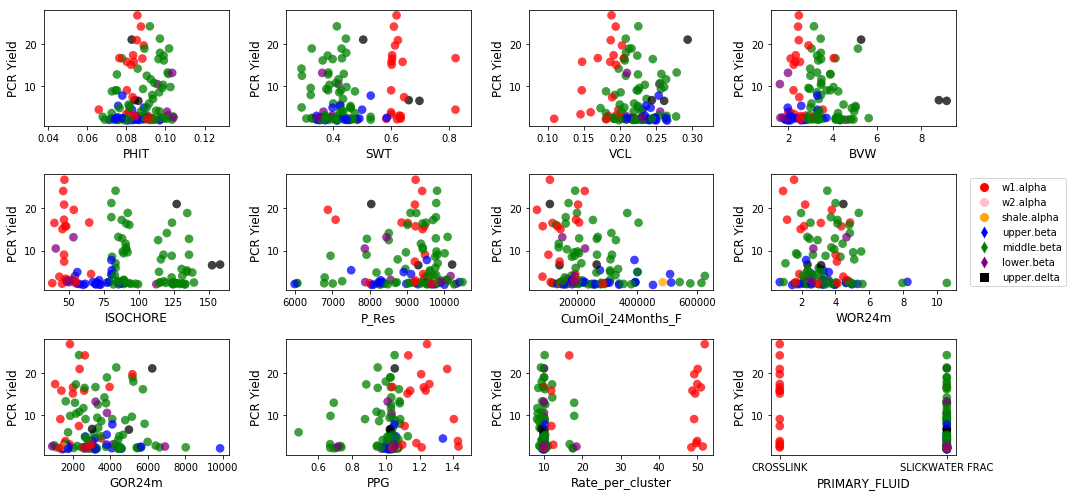

In [37]:
fig, axes = plt.subplots(3,4, figsize=(15, 7))
axes = axes.ravel()
for i, x in enumerate(plotcolumns):
    axes[i].scatter(WellData2[x], WellData2.PCRYield, s=75, edgecolor='none',
                alpha=0.75, c=WellData2.FormationColor)
    axes[i].set_xlabel(x, size=12)
    axes[i].set_ylabel('PCR Yield', size=12)

F0 = Line2D([],[], marker='o', color='w', markerfacecolor='red', label='w1.alpha', markersize=10)
F1 = Line2D([],[], marker='o', color='w', markerfacecolor='pink', label='w2.alpha', markersize=10)
F2 = Line2D([],[], marker='o', color='w', markerfacecolor='orange', label='shale.alpha', markersize=10)
F3 = Line2D([],[], marker='d', color='w', markerfacecolor='blue', label='upper.beta', markersize=10)
F4 = Line2D([],[], marker='d', color='w', markerfacecolor='green', label='middle.beta', markersize=10)
F5 = Line2D([],[], marker='d', color='w', markerfacecolor='purple', label='lower.beta', markersize=10)
F6 = Line2D([],[], marker='s', color='w', markerfacecolor='black', label='upper.delta', markersize=10)
axes[7].legend(handles=[F0,F1,F2,F3,F4,F5,F6],loc='center left', bbox_to_anchor=(1.05, 0.5))    
fig.tight_layout()

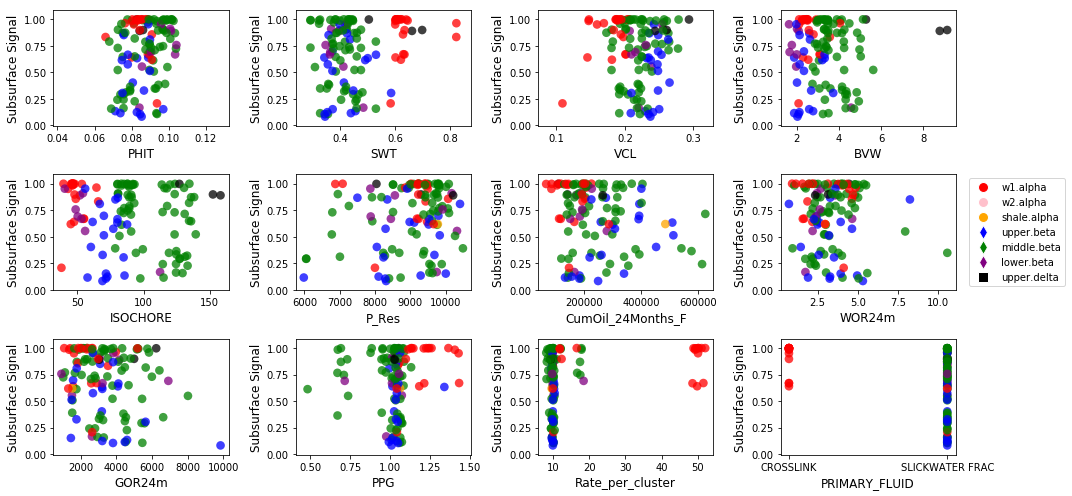

In [39]:
fig, axes = plt.subplots(3,4, figsize=(15, 7))
axes = axes.ravel()
for i, x in enumerate(plotcolumns):
    axes[i].scatter(WellData2[x], WellData2.Unknown, s=75, edgecolor='none',
                alpha=0.75, c=WellData2.FormationColor)
    axes[i].set_xlabel(x, size=12)
    axes[i].set_ylabel('Subsurface Signal', size=12)

axes[7].legend(handles=[F0,F1,F2,F3,F4,F5,F6],loc='center left', bbox_to_anchor=(1.05, 0.5))    
fig.tight_layout()

##### Thoughts:
- There is no clear correlation between PCRYield and geologic, completions and production data (maybe porosity and clay volume?)
- The only parameters that seem to be correlating with subsurface signal are injection rate during frac'ing and the type of primary injected fluid. 
- Most of these wells have been online hundreds of days and I'm not sure if there is a physical/chemical/biological explanation for the observed correlation. 

##### t-test:

In [38]:
cat1 = WellData2[WellData2['PRIMARY_FLUID']=='CROSSLINK']
cat2 = WellData2[WellData2['PRIMARY_FLUID']=='SLICKWATER FRAC']

ttest_ind(cat1['Unknown'], cat2['Unknown'])

Ttest_indResult(statistic=3.4839249201549758, pvalue=0.00069606907726252321)

##### Thoughts:
- p-value is < 0.05, hence we're confident that the observed difference in subsurface signal of wells with CROSSLINK and SLICKWATER frac fluids is real

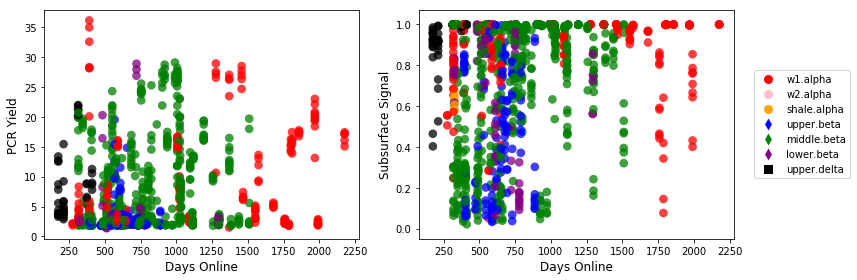

In [128]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
axes = axes.ravel()
axes[0].scatter(fluids.DaysOnline.astype(int), fluids.PCRYield, s=75, edgecolor='none',
                alpha=0.75, c=fluids.FormationColor)
axes[0].set_xlabel('Days Online', size=12)
axes[0].set_ylabel('PCR Yield', size=12)

axes[1].scatter(fluids.DaysOnline.astype(int), fluids.Unknown, s=75, edgecolor='none',
                alpha=0.75, c=fluids.FormationColor)
axes[1].set_xlabel('Days Online', size=12)
axes[1].set_ylabel('Subsurface Signal', size=12)

axes[1].legend(handles=[F0,F1,F2,F3,F4,F5,F6],loc='center left', bbox_to_anchor=(1.05, 0.5))    
fig.tight_layout()

##### Thoughts: 
- PCRYield and Subsurface Signal don't appear to correlate with the number of days a well has been online 

#### A General Look at the Wells:

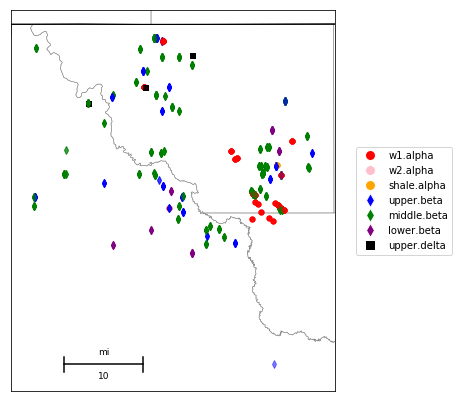

In [129]:
fig, ax = plt.subplots(figsize=(6,6))

Wells = fluids.groupby('Well').first()
lat = list(Wells.Latitude.astype(float))
long = list(Wells.Longitude.astype(float))

map = Basemap(llcrnrlon=min(long)-0.05, urcrnrlon=max(long)+0.05,
                  lon_0=0.5*(min(long)+max(long)),
                  llcrnrlat=min(lat)-0.05, urcrnrlat=max(lat)+0.05,
                  lat_0=0.5*(min(lat)+max(lat)),
                  projection='tmerc')
# add county boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/cb_2017_us_county_500k',
                  'counties',drawbounds=True,
                  linewidth=0.45,color='gray')
# add state boundaries
map.readshapefile('/home/jovyan/my-conda-envs/qiime2-2018.8/share/basemap/st99_d00','states',
                  drawbounds=True,linewidth=1,color='black')

for i, r in fluids.iterrows():
    x, y = map(r.Longitude, r.Latitude)
    map.plot(x, y, marker=r.Marker, c=r.FormationColor, ms=5, alpha=0.5)
    
map.drawmapscale(min(long)+0.15, min(lat), 0.5*(min(long)+max(long)), 0.5*(min(lat)+max(lat)), 
                 length=10, barstyle='simple', units='mi')

ax.legend(handles=[F0,F1,F2,F3,F4,F5,F6],loc='center left', bbox_to_anchor=(1.05, 0.5))

fig.tight_layout()
fig.savefig('./images/map.png', dpi=300, bbox_inches='tight')

In [39]:
# number of early-time (<30 days) fluids samples
fluids.loc[fluids.DaysOnline.astype(int) < 30].shape[0]

0

In [40]:
WellData.GORColor = bpl.get_color_map(sample_md=WellData.WCA_GOR, 
                                         continuous=True, colormap='Reds').copy()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


In [41]:
WellData.WORColor = bpl.get_color_map(sample_md=WellData.WOR24m, 
                                         continuous=True, colormap='Blues').copy()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


''

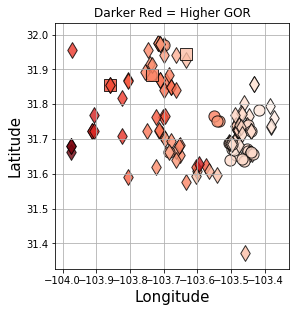

In [43]:
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c, m in zip(WellData.SH_Long, WellData.SH_Lat, WellData.GORColor, 
                        WellData.Marker):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Red = Higher GOR')
,

##### Thoughts:
- There is a GOR gradient across the area of interest 

''

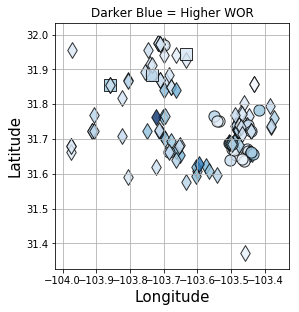

In [41]:
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c, m in zip(WellData.SH_Long, WellData.SH_Lat, WellData.WORColor, 
                        WellData.Marker):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Blue = Higher WOR')
,

In [42]:
WellData2.PCRYieldColor = bpl.get_color_map(sample_md=WellData2.PCRYield, 
                                         continuous=True, colormap='Greens').copy()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


In [43]:
WellData2.SubsurfaceSignalColor = bpl.get_color_map(sample_md=WellData2.Unknown, 
                                         continuous=True, colormap='Greens').copy()

/home/jovyan/my-conda-envs/qiime2-2018.8/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  from ipykernel import kernelapp as app


''

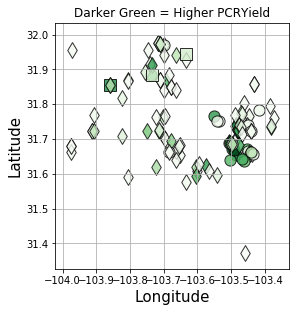

In [44]:
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c, m in zip(WellData2.SH_Long, WellData2.SH_Lat, WellData2.PCRYieldColor, 
                        WellData2.Marker):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Green = Higher PCRYield')
,

''

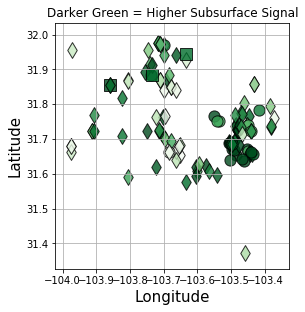

In [47]:
fig, ax = plt.subplots(1, figsize=(4, 4))

for xp, yp, c, m in zip(WellData2.SH_Long, WellData2.SH_Lat, WellData2.SubsurfaceSignalColor, 
                        WellData2.Marker):
    ax.scatter([xp], [yp], c=c, marker=m, s=125, alpha=0.8, edgecolor='k')

ax.grid()
plt.tight_layout()
ax.set_xlabel('Longitude', size=15)
ax.set_ylabel('Latitude', size=15)
ax.set_title('Darker Green = Higher Subsurface Signal')
,

#### PCoA Plots - All Samples:

In [111]:
%%capture
# Make Tree: uses the DNA marker sequences themselves to create a phylogenetic tree that relates how similar each DNA marker sequence is to one another.
tree = make_tree(features.DenoisedSequenceVariant, overwrite=False, n_threads=6)

In [112]:
%%capture
# Get distance metrics
dms = get_dms(data, sampling_depth=5000, rooted_tree=tree, overwrite=False, n_jobs=1)

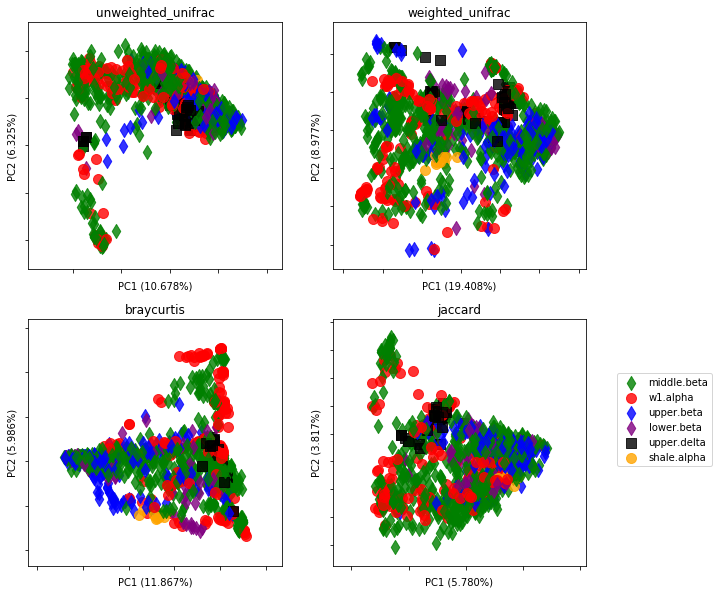

In [113]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for i, (metric, dm) in enumerate(dms.items()):

    dm_, map_ = filter_dm_and_map(dm, fluids.Formation)
    
    bpl.plot_pcoa(dm_,
                  color_md=fluids.Formation,
                  color=fluids.FormationColor,
                  marker=fluids.Marker,
                  fig=fig,
                  ax=axes[i])
    axes[i].set_title(metric)
    axes[i].legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
legend = collections.OrderedDict(zip(labels, handles))

axes[3].legend(legend.values(), legend.keys(), bbox_to_anchor=(1.1, 0.8))
fig.savefig('./images/PCoA_color_by_formation.png', dpi=300, bbox_inches='tight')

##### Thoughts:
- There is a large overlap between alpha and beta wells

#### PCoA Plots - Samples Passing QC

In [114]:
# select fluid samples that pass QC 
fluids_passQC = fluids.loc[fluids.PassQC==1].copy() 
fluids_passQC.to_csv('./shared/fluids_passing_qc.txt', sep='\t')

In [43]:
# data for fluids passing QC
data2 = data.loc[fluids_passQC.index].copy()

In [116]:
%%capture
# Get distance metrics
dms = get_dms(data2, sampling_depth=5000, rooted_tree=tree, output_dir='bdiv_passQC', overwrite=False, n_jobs=1)

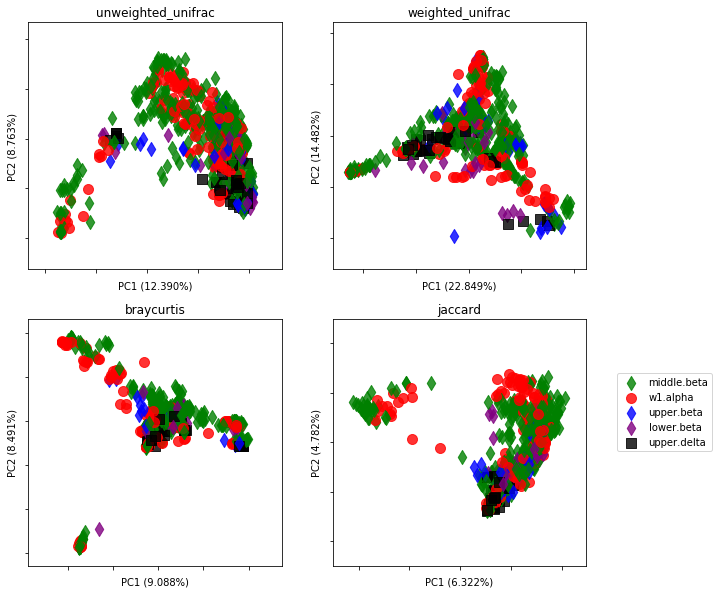

In [117]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.ravel()

for i, (metric, dm) in enumerate(dms.items()):

    dm_, map_ = filter_dm_and_map(dm, fluids_passQC.Formation)
    
    bpl.plot_pcoa(dm_,
                  color_md=fluids_passQC.Formation,
                  color=fluids_passQC.FormationColor,
                  marker=fluids_passQC.Marker,
                  fig=fig,
                  ax=axes[i])
    axes[i].set_title(metric)
    axes[i].legend().remove()

handles, labels = axes[0].get_legend_handles_labels()
legend = collections.OrderedDict(zip(labels, handles))

axes[3].legend(legend.values(), legend.keys(), bbox_to_anchor=(1.1, 0.8))
fig.savefig('./images/PCoA_color_by_formation_fluidsPassQC.png', dpi=300, bbox_inches='tight')

In [118]:
fluids_passQC.groupby('Formation').size()

Formation
lower.beta      36
middle.beta    347
upper.beta      41
upper.delta     38
w1.alpha       155
dtype: int64

In [119]:
fluids.groupby('Formation').size()

Formation
lower.beta      72
middle.beta    602
shale.alpha     10
upper.beta     161
upper.delta     43
w1.alpha       202
dtype: int64

In [44]:
len(fluids.Well.unique())

119

In [45]:
len(fluids_passQC.Well.unique())

90

#### Hierarchical Clustering - All Samples:

In [122]:
# Create our summarized Well data counts
data_wells = data.reindex(fluids.index).copy()
data_wells = rarefy(data_wells, 5000)
data_wells = data_wells.groupby(fluids.Well).sum()

In [123]:
# create the distances and hierarchy using scipy 
Y = pdist(data_wells, 'correlation')
Z = hierarchy.linkage(Y, 'single')

In [124]:
# To color code well labels by their landing zones
data_wells['FormationColor'] = fluids.groupby('Well').FormationColor.first()

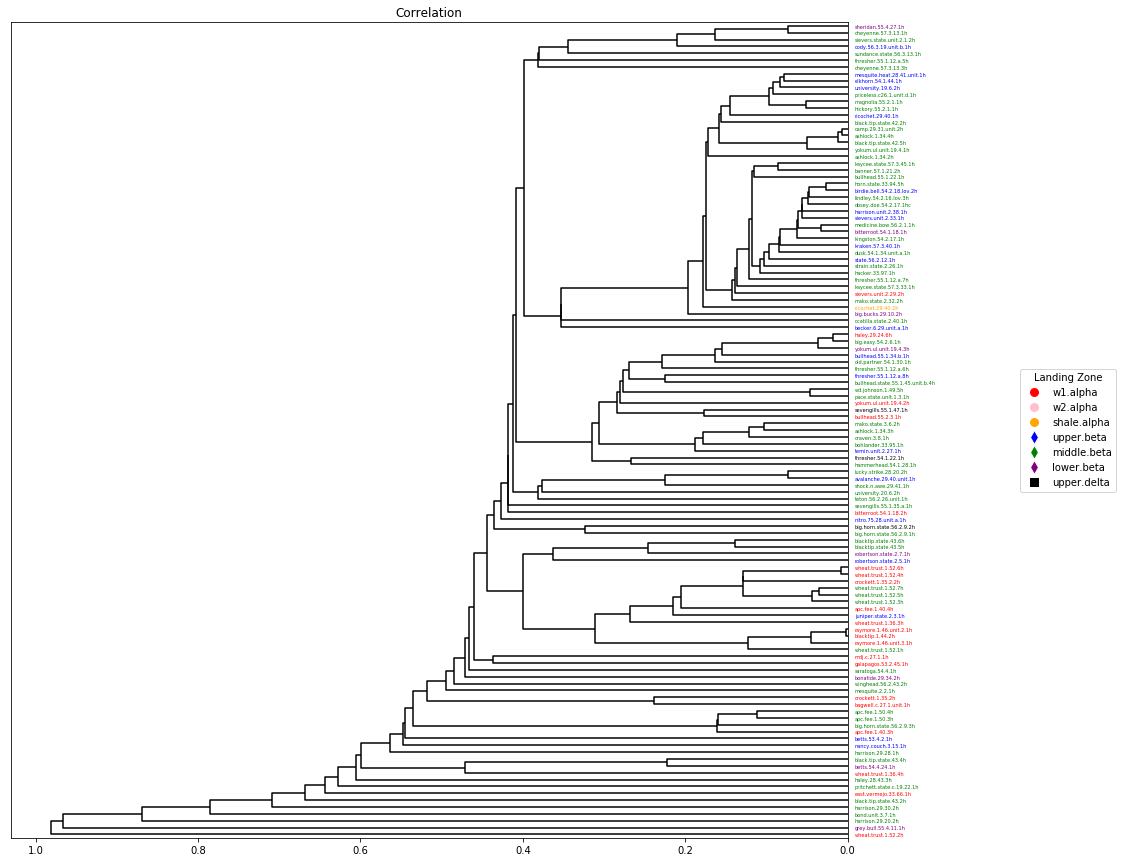

In [130]:
# Make dendrogram plot
fig, ax = plt.subplots(1, figsize=(15, 15))

hierarchy.dendrogram(Z,
                     orientation='left',
                     ax=ax,
                     labels=data_wells.index,
                     link_color_func=lambda x: 'black')

ax.set_title('Correlation')
,

# Apply the right color to each label
xlbls = ax.get_ymajorticklabels()
num = -1
for lbl in xlbls:
    num += 1
    val = data_wells.loc[data_wells.index == xlbls[num].get_text(),'FormationColor'][0]
    lbl.set_color(val)
    
ax.legend(handles=[F0,F1,F2,F3,F4,F5,F6], loc='center left', bbox_to_anchor=(1.2, 0.5), title='Landing Zone')

,
fig.savefig('./images/Dendrogram.png', dpi=300, bbox_inches='tight')

##### Thoughts:
- We don't see a clear clustering of wells based on landing zone

#### Hierarchical Clustering - Samples Passing QC:

In [131]:
# Create our summarized Well data counts
data_wells2 = data.reindex(fluids_passQC.index).copy()
data_wells2 = rarefy(data_wells2, 5000)
data_wells2 = data_wells2.groupby(fluids_passQC.Well).sum()

In [139]:
# create the distances and hierarchy using scipy 
Y = pdist(data_wells2, 'correlation')
Z = hierarchy.linkage(Y, 'single')

In [140]:
# To color code well labels by their landing zones
data_wells2['FormationColor'] = fluids_passQC.groupby('Well').FormationColor.first()

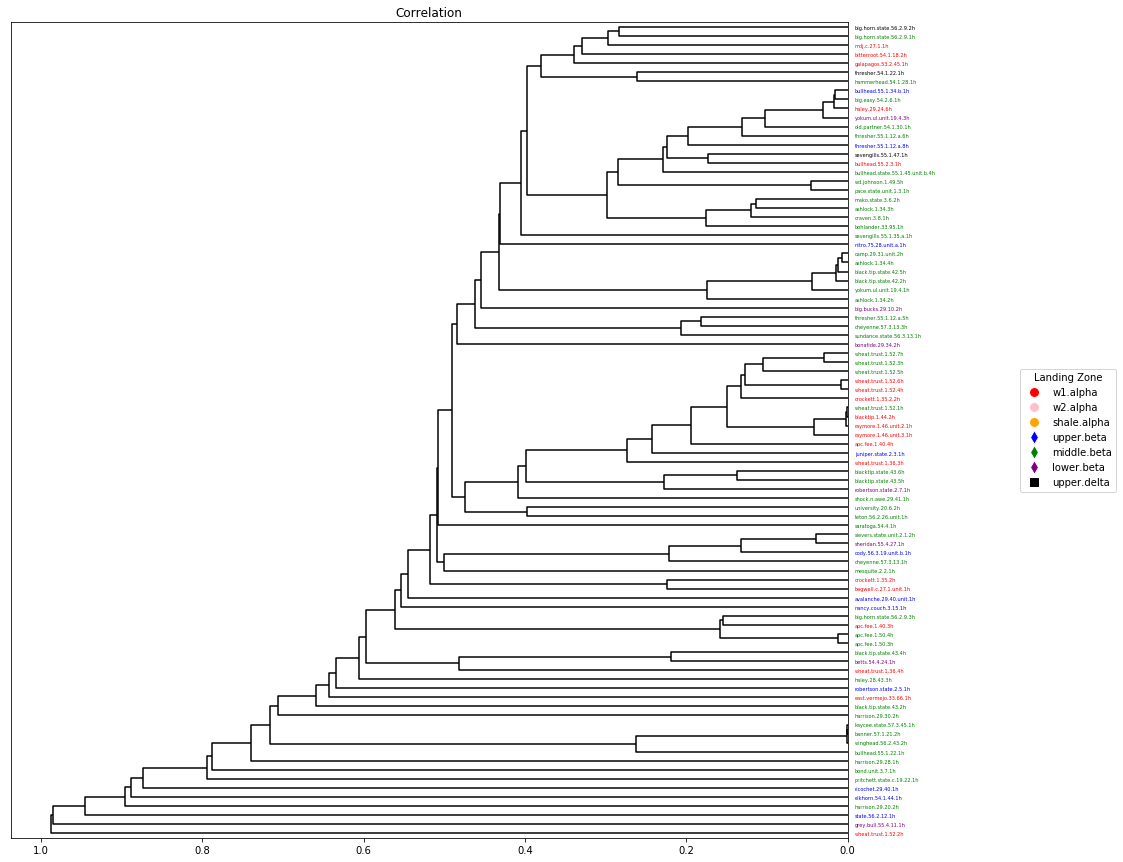

In [141]:
# Make dendrogram plot
fig, ax = plt.subplots(1, figsize=(15, 15))

hierarchy.dendrogram(Z,
                     orientation='left',
                     ax=ax,
                     labels=data_wells2.index,
                     link_color_func=lambda x: 'black')

ax.set_title('Correlation')
,

# Apply the right color to each label
xlbls = ax.get_ymajorticklabels()
num = -1
for lbl in xlbls:
    num += 1
    val = data_wells2.loc[data_wells2.index == xlbls[num].get_text(),'FormationColor'][0]
    lbl.set_color(val)
    
ax.legend(handles=[F0,F1,F2,F3,F4,F5,F6], loc='center left', bbox_to_anchor=(1.2, 0.5), title='Landing Zone')

,
fig.savefig('./images/Dendrogram.png', dpi=300, bbox_inches='tight')

##### Thoughts:
- We don't see a clear clustering of wells based on landing zone

#### Leave One Out Analysis using ST - All Samples:

In [28]:
try:
    # if the results already exist
    results = pd.read_csv('./shared/formation_contributions_all_samples.txt', sep='\t', index_col=0)  
except:
    # if the results don't exist and we need to compute them
    fluids_wells = fluids.groupby('Well').first()
    
    data_sources = data.loc[fluids.index].copy()
    data_sources = data_sources.groupby(fluids.Well).sum()
    data_sources = rarefy(data_sources, 5000)
    
    mp_results = {}

    for well in data_sources.index:
        _sink = data_sources.loc[well].to_frame().T
        _wells = data_sources.index.tolist()
        _sourcenames = [x for x in _wells if x not in well]
        _sources = data_sources.loc[_sourcenames]
        _sources = _sources.groupby(fluids.groupby('Well').first()['Formation']).mean()
        _mp, _, _ = gibbs(_sources, _sink, **st_params)
        mp_results[well] = _mp
    
    results = pd.concat([r for r in mp_results.values()])
    
    results['Formation'] = fluids_wells.loc[results.index, 'Formation']
    
    results.to_csv('./shared/formation_contributions_all_samples.txt', sep='\t')

In [47]:
results.groupby('Formation').mean()

,Unknown,lower.beta,middle.beta,shale.alpha,upper.beta,upper.delta,w1.alpha
Formation,,,,,,,
lower.beta,0.228963,0.011980,0.244450,0.086020,0.228505,0.116993,0.083090
middle.beta,0.096700,0.100240,0.271032,0.133570,0.240217,0.062233,0.096009
shale.alpha,0.059880,0.007220,0.586040,NaN,0.345040,0.000440,0.001380
upper.beta,0.182919,0.079031,0.170596,0.134492,0.380693,0.018157,0.034112
upper.delta,0.118267,0.075860,0.293693,0.002073,0.014760,0.429627,0.065720
w1.alpha,0.104644,0.072933,0.086925,0.024543,0.091578,0.088029,0.531349


In [29]:
# create a column for target formation contribution
for well, g in results.iterrows():
    results.loc[well, 'TargetContrib'] = g[g.Formation]

In [46]:
results.Formation.replace({'w1.alpha': '1_w1.alpha',
                                'w2.alpha': '2_w2.alpha',
                                'shale.alpha':'3_shale.alpha',
                                'upper.beta': '4_upper.beta',
                                'middle.beta': '5_middle.beta',
                                'lower.beta': '6_lower.beta',
                                'upper.delta':'7_upper.delta'}, inplace=True)

In [47]:
results.sort_values(by=['Formation', 'w1.alpha', 'shale.alpha', 'upper.beta', 'middle.beta',
                       'lower.beta', 'upper.delta'], inplace=True)

''

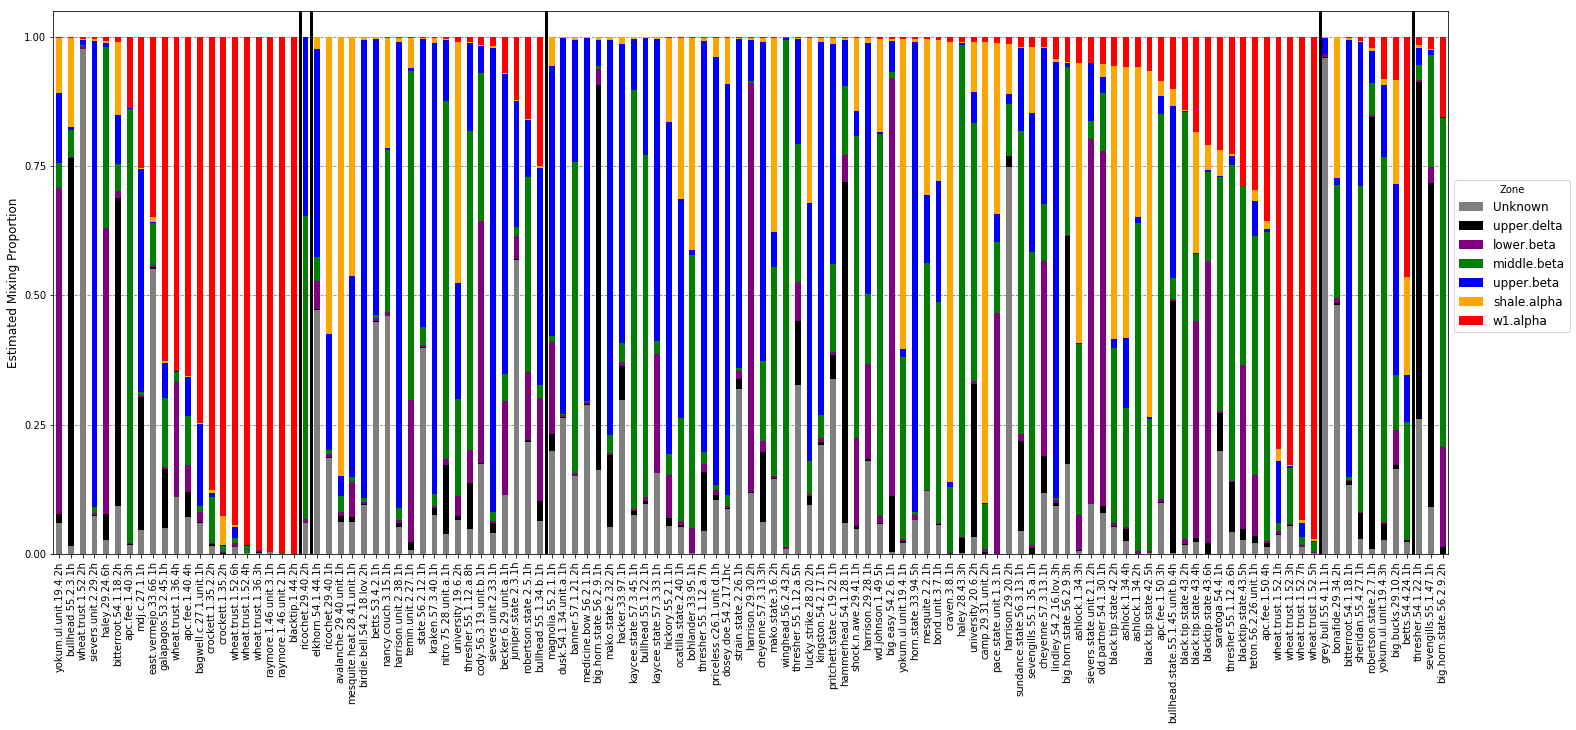

In [49]:
fig, ax = plt.subplots(1, figsize=(25, 10))

results[['Unknown', 'upper.delta','lower.beta','middle.beta','upper.beta','shale.alpha','w1.alpha']].plot(kind='bar', stacked=True, ax=ax,
             color=['gray', 'black','purple', 'green', 'blue', 'orange', 'red'])

ax.set_ylabel('Estimated Mixing Proportion', size=12)
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel('')
ax.yaxis.grid(color='grey', linestyle='--')
ax.set_axisbelow(True)
ax.legend(bbox_to_anchor=(1, 0.7), prop={'size': 12}, title='Zone')

[ax.axvline(_x, linewidth=3, color='k') for _x in [20.5, 21.5, 41.5, 107.5, 115.5]]
,

#### Leave One Out Analysis using ST - Samples passing QC:

In [30]:
try:
    # if the results already exist
    results2 = pd.read_csv('./shared/formation_contributions_samples_passingQC.txt', sep='\t', index_col=0)  
except:
    # if the results don't exist and we need to compute them
    fluids_wells2 = fluids_passQC.groupby('Well').first()
    
    data_sources2 = data.loc[fluids_passQC.index].copy()
    data_sources2 = data_sources2.groupby(fluids_passQC.Well).sum()
    data_sources2 = rarefy(data_sources2, 5000)
    
    mp_results2 = {}

    for well in data_sources2.index:
        _sink = data_sources2.loc[well].to_frame().T
        _wells = data_sources2.index.tolist()
        _sourcenames = [x for x in _wells if x not in well]
        _sources = data_sources2.loc[_sourcenames]
        _sources = _sources.groupby(fluids_passQC.groupby('Well').first()['Formation']).mean()
        _mp, _, _ = gibbs(_sources, _sink, **st_params)
        mp_results[well] = _mp
    
    results2 = pd.concat([r for r in mp_results2.values()])
    
    results2['Formation'] = fluids_wells2.loc[results2.index, 'Formation']
    
    results2.to_csv('./shared/formation_contributions_samples_passingQC.txt', sep='\t')

In [48]:
results2.groupby('Formation').mean()

,lower.beta,middle.beta,upper.beta,upper.delta,w1.alpha,Unknown
Formation,,,,,,
lower.beta,0.011540,0.299237,0.189083,0.142306,0.102449,0.255386
middle.beta,0.083904,0.532722,0.123848,0.066784,0.113488,0.079254
upper.beta,0.122444,0.268645,0.171575,0.039660,0.029733,0.367944
upper.delta,0.023933,0.338853,0.062273,0.398487,0.053180,0.123273
w1.alpha,0.030449,0.114339,0.045893,0.099206,0.601498,0.108615


In [31]:
# create a column for target formation contribution
for well, g in results2.iterrows():
    results2.loc[well, 'TargetContrib'] = g[g.Formation]

In [50]:
results2.Formation.replace({'w1.alpha': '1_w1.alpha',
                                'w2.alpha': '2_w2.alpha',
                                'shale.alpha':'3_shale.alpha',
                                'upper.beta': '4_upper.beta',
                                'middle.beta': '5_middle.beta',
                                'lower.beta': '6_lower.beta',
                                'upper.delta':'7_upper.delta'}, inplace=True)

In [51]:
results2.sort_values(by=['Formation', 'w1.alpha', 'upper.beta', 'middle.beta',
                       'lower.beta', 'upper.delta'], inplace=True)

''

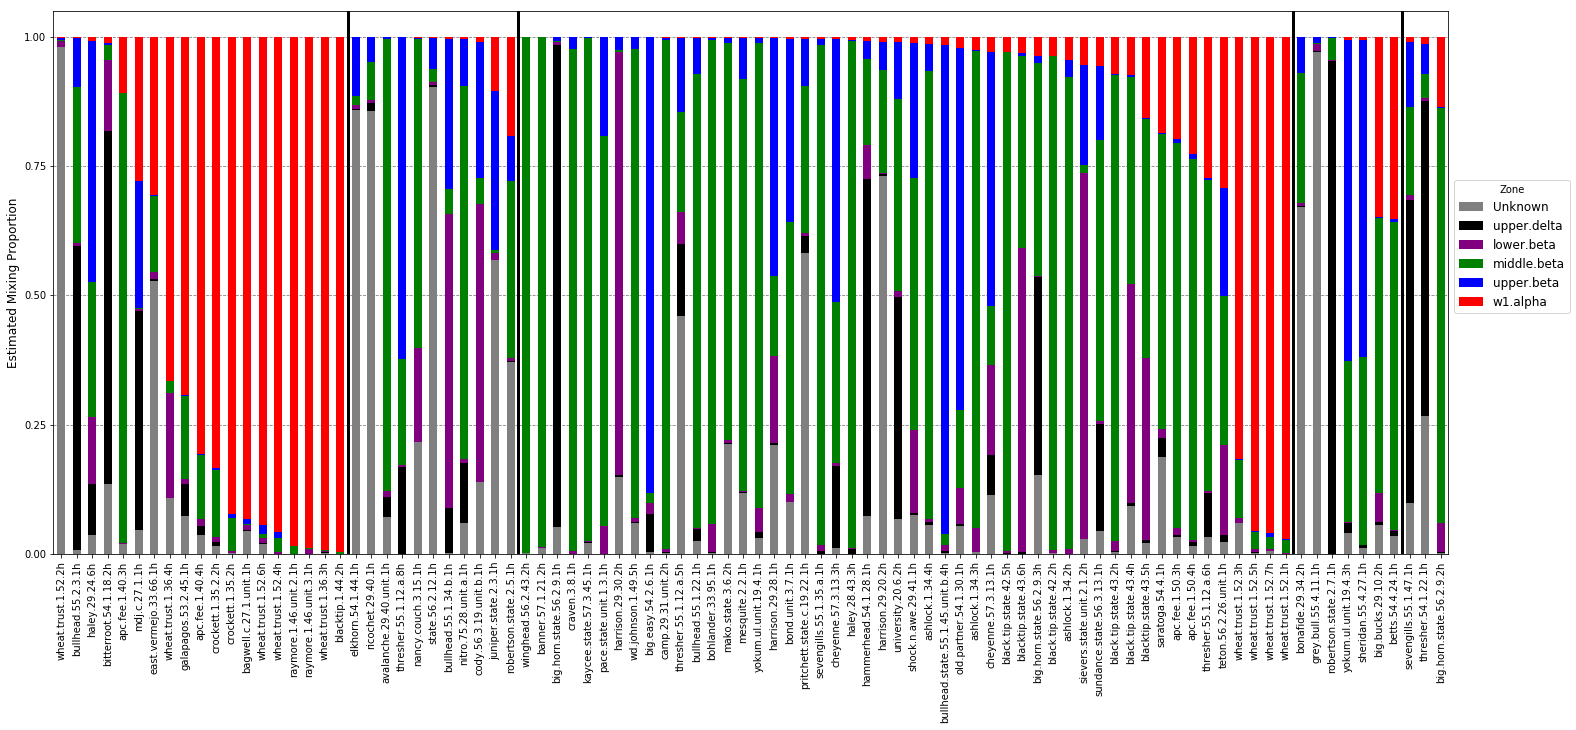

In [47]:
fig, ax = plt.subplots(1, figsize=(25, 10))

results2[['Unknown', 'upper.delta','lower.beta','middle.beta','upper.beta','w1.alpha']].plot(kind='bar', stacked=True, ax=ax,
             color=['gray', 'black','purple', 'green', 'blue', 'red'])

ax.set_ylabel('Estimated Mixing Proportion', size=12)
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xlabel('')
ax.yaxis.grid(color='grey', linestyle='--')
ax.set_axisbelow(True)
ax.legend(bbox_to_anchor=(1, 0.7), prop={'size': 12}, title='Zone')

[ax.axvline(_x, linewidth=3, color='k') for _x in [18.5, 29.5, 79.5, 86.5]]
,

##### Target Formation Contribution vs. Days Online

In [57]:
s1 = fluids.groupby('Well').DaysOnline.mean()

In [58]:
s2 = fluids.groupby('Well').FormationColor.first()

In [59]:
s3 = results.TargetContrib

In [60]:
df = pd.concat([s1, s2, s3], axis=1)

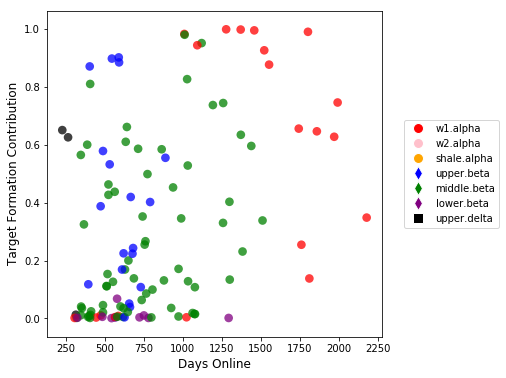

In [109]:
fig, ax = plt.subplots(1, figsize=(6,6))

ax.scatter(df.DaysOnline, df.TargetContrib, s=75, edgecolor='none',
                alpha=0.75, c=df.FormationColor)

ax.set_ylabel('Target Formation Contribution', size=12)
ax.set_xlabel('Days Online', size=12)

ax.legend(handles=[F0,F1,F2,F3,F4,F5,F6],loc='center left', bbox_to_anchor=(1.05, 0.5))    

##### Thoughts:
- There is no clear correlation between target formation contribution and the number of days each well has been online